In [1]:
!pip install datasets

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import numpy as np
from datasets import load_dataset
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tokenizers import Tokenizer, models, pre_tokenizers, trainers
import gensim.downloader as api


2024-04-26 13:07:30.148286: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 13:07:32.970140: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
# Load the dataset
dataset = load_dataset("surrey-nlp/PLOD-CW")
train_data, val_data, test_data = dataset["train"], dataset["validation"], dataset["test"]

# Function to extract text and labels from the dataset
def prepare_data(data):
    texts = [' '.join(tokens) for tokens in data['tokens']]
    labels = [tags for tags in data['ner_tags']]
    return texts, labels

# Preparing the data
X_train, y_train = prepare_data(train_data)
X_val, y_val = prepare_data(val_data)
X_test, y_test = prepare_data(test_data)


In [6]:
# Initialize and train the tokenizer
tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
trainer = trainers.WordPieceTrainer(vocab_size=10000, special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"])
concatenated_texts = X_train + X_val + X_test  
tokenizer.train_from_iterator(concatenated_texts, trainer=trainer)


In [7]:
# Encode the texts into sequences of integers
X_train_enc = [tokenizer.encode(text).ids for text in X_train]
X_val_enc = [tokenizer.encode(text).ids for text in X_val]
X_test_enc = [tokenizer.encode(text).ids for text in X_test]

# Padding sequences
max_length = max(max(len(seq) for seq in X_train_enc), max(len(seq) for seq in X_val_enc), max(len(seq) for seq in X_test_enc))
X_train_pad = pad_sequences(X_train_enc, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val_enc, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_enc, maxlen=max_length, padding='post')


In [8]:
mlb = MultiLabelBinarizer()
y_train_encoded = mlb.fit_transform([set(tags) for tags in y_train])
y_val_encoded = mlb.transform([set(tags) for tags in y_val])
y_test_encoded = mlb.transform([set(tags) for tags in y_test])


In [9]:
# Load a pre-trained FastText model
fasttext_model = api.load("fasttext-wiki-news-subwords-300")

# Initialize the embedding matrix
embedding_matrix_fasttext = np.zeros((len(tokenizer.get_vocab()) + 1, 300))
for word, idx in tokenizer.get_vocab().items():
    embedding_matrix_fasttext[idx] = fasttext_model.get_vector(word) if word in fasttext_model else np.zeros(300)

# Building the model
model_fnn_fasttext = Sequential([
    Embedding(input_dim=len(tokenizer.get_vocab()) + 1, output_dim=300, weights=[embedding_matrix_fasttext], trainable=False),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(y_train_encoded.shape[1], activation='sigmoid')
])

# Compile the model
model_fnn_fasttext.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


2024-04-26 13:09:53.863955: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-26 13:09:53.892422: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
model_fnn_fasttext.fit(X_train_pad, y_train_encoded, epochs=10, validation_data=(X_val_pad, y_val_encoded), batch_size=32)


Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.1193 - loss: 1.1903 - val_accuracy: 0.0794 - val_loss: 0.4219
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.1082 - loss: 0.3890 - val_accuracy: 0.0794 - val_loss: 0.3893
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.0982 - loss: 0.3413 - val_accuracy: 0.0794 - val_loss: 0.3974
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.1031 - loss: 0.3462 - val_accuracy: 0.0794 - val_loss: 0.3774
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.1003 - loss: 0.3198 - val_accuracy: 0.0794 - val_loss: 0.4065
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.1106 - loss: 0.3447 - val_accuracy: 0.0794 - val_loss: 0.4008
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.0952 - loss: 0.3448 - val_accuracy: 0.0794 - val_loss: 0.3939
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.0904 - loss: 0.3348 - val_accuracy: 0.

In [11]:
test_loss, test_acc = model_fnn_fasttext.evaluate(X_test_pad, y_test_encoded, verbose=2)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")


5/5 - 0s - 21ms/step - accuracy: 0.1438 - loss: 0.4270
Test accuracy: 0.1437908560037613, Test loss: 0.42697522044181824


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


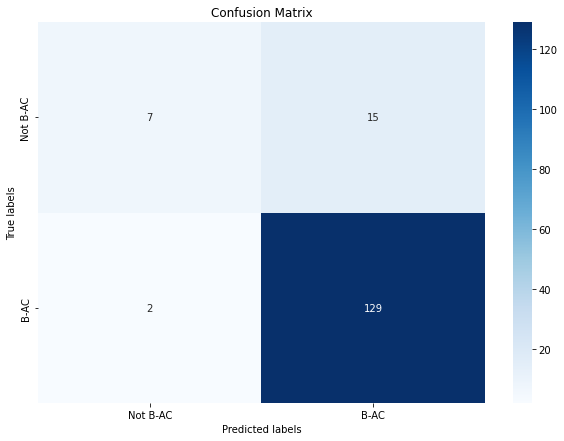

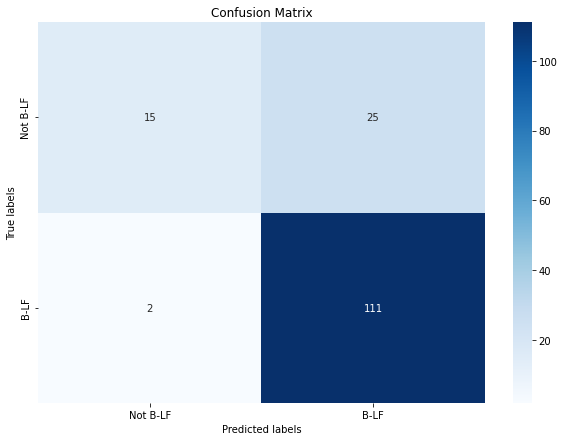

/user/HS400/dd00830/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


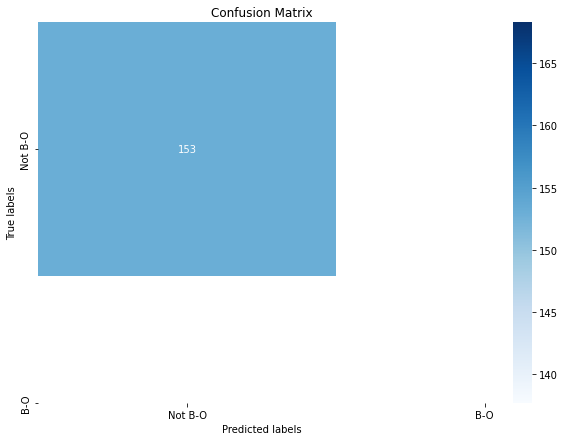

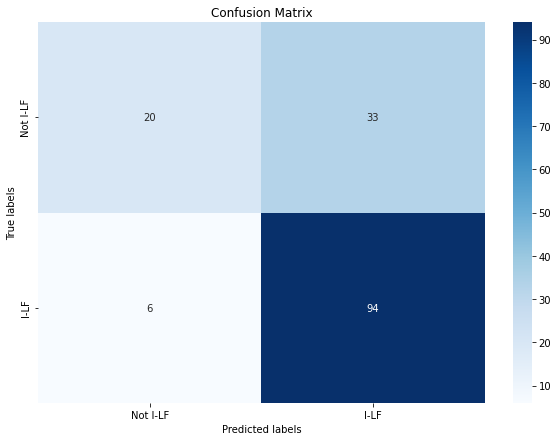

              precision    recall  f1-score   support

        B-AC       0.90      0.98      0.94       131
        B-LF       0.82      0.98      0.89       113
         B-O       1.00      1.00      1.00       153
        I-LF       0.74      0.94      0.83       100

   micro avg       0.87      0.98      0.92       497
   macro avg       0.86      0.98      0.91       497
weighted avg       0.88      0.98      0.92       497
 samples avg       0.87      0.98      0.90       497

[[20 33]
 [ 6 94]]


In [12]:
import numpy as np

# Predict probabilities for test set
y_probs = model_fnn_fasttext.predict(X_test_pad) 

# Convert probabilities to binary predictions
y_pred = (y_probs > 0.5).astype(int)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

for i, class_name in enumerate(mlb.classes_):
    cm = confusion_matrix(y_test_encoded[:, i], y_pred[:, i])
    plot_confusion_matrix(cm, [f'Not {class_name}', class_name])
# Generate a classification report
report = classification_report(y_test_encoded, y_pred, target_names=mlb.classes_)
print(report)

print(cm)